In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [2]:
data = pd.read_csv('crypto_data_cleaned.csv' ,index_col=0).dropna()

In [4]:
# Daily Linear Returns (%)
datareturns = data.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

In [12]:
#Normalizing the data and plotting
ndata = (data / data.iloc[0]*100)

In [ ]:
ndata

In [ ]:
#ndata=(data-data.min())/(data.max()-data.min())

In [6]:
datareturns = (datareturns / datareturns.iloc[0]*100)

In [ ]:
#data = (data_raw - data_raw.mean()) / data_raw.std()

In [ ]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler().fit(datareturns)
# ndata = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)

In [ ]:
# datareturns

In [ ]:
# ndata=(data-data.min())/(data.max()-data.min())

In [ ]:
ndata

In [ ]:
# Visualizing Log Returns for the DJIA 
#plt.figure(figsize=(16, 5))
#plt.title("AAPL Return")
#plt.ylabel("Return")
plt.figure(figsize=(16, 5))
ndata.plot()
#plt.grid(True);
plt.legend()

#plt.show()

In [13]:
# Dividing the dataset into training and testing sets
percentage = int(len(ndata) * 0.8)
X_train = ndata[:percentage]
X_test = ndata[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = ndata.columns.values
n_tickers = len(stock_tickers)

In [14]:
'''PCA !!'''
pca = PCA()
PrincipalComponent=pca.fit(X_train)

In [15]:
#FIRST PC / Eigenvector
pca.components_[0]

array([0.33181064, 0.1321239 , 0.03995499, 0.00718819, 0.07408921,
       0.04568045, 0.8305049 , 0.02918776, 0.0287383 , 0.22154839,
       0.33142094, 0.03354367, 0.1084255 ])

In [16]:
len(pca.components_)

13

,Explained Variance
0,93.32%
1,98.37%
2,99.23%
3,99.72%
4,99.87%
5,99.93%
6,99.97%
7,99.98%
8,99.99%
9,99.99%


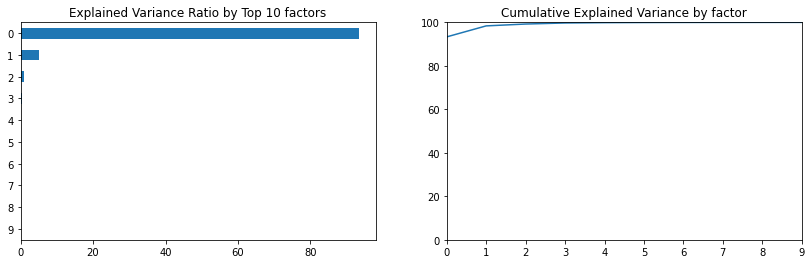

In [17]:
#Explained Variance per EigenVector
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

In [18]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()
print(pca.components_[0])
weights[0]

[0.33181064 0.1321239  0.03995499 0.00718819 0.07408921 0.04568045
 0.8305049  0.02918776 0.0287383  0.22154839 0.33142094 0.03354367
 0.1084255 ]


array([0.14985463, 0.05967071, 0.01804475, 0.00324638, 0.03346068,
       0.02063052, 0.3750784 , 0.01318198, 0.01297899, 0.10005723,
       0.14967863, 0.01514922, 0.04896788])

   _ADAUSDT_  _BTCUSDT_  _TRXUSDT_  _EOSUSDT_  _NEOUSDT_  _XLMUSDT_  \
0   0.331811   0.132124   0.039955   0.007188   0.074089   0.045680   
1   0.547985  -0.017885   0.038313   0.021863   0.041002   0.002981   
2  -0.600324  -0.083632   0.119205   0.050055   0.220681   0.014895   
3  -0.251772  -0.481568  -0.017887   0.025503   0.073659  -0.070694   
4  -0.363958   0.571335   0.023983   0.056306   0.018633   0.134727   

   _LINKUSDT_  _ZECUSDT_  _XRPUSDT_  _ETHUSDT_  _BNBUSDT_  _LTCUSDT_  \
0    0.830505   0.029188   0.028738   0.221548   0.331421   0.033544   
1   -0.531630   0.010868   0.040855   0.236877   0.512331   0.013020   
2   -0.006040   0.080995   0.091606  -0.204239   0.711052   0.056463   
3    0.102887   0.009808   0.030740   0.182694  -0.195122  -0.045088   
4   -0.119502   0.046357   0.017673   0.656145  -0.090040   0.232898   

   _ETCUSDT_  
0   0.108425  
1   0.304263  
2  -0.038666  
3   0.779871  
4   0.096173  
   _ADAUSDT_  _BTCUSDT_  _TRXUSDT_  _EOSUSDT_  _NE

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5383554210>],
      dtype=object)

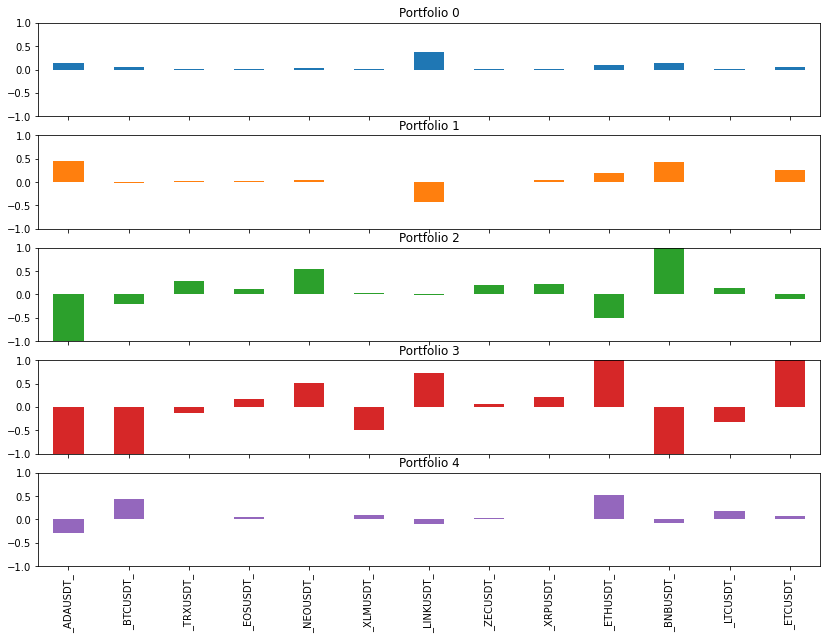

In [19]:
NumComponents=5
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=data.columns)
print(topPortfolios.head(5))
#Divide obs by the SUM of ROW (so... make each row sum to 1.0)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)

print(eigen_portfolios.head(5))
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

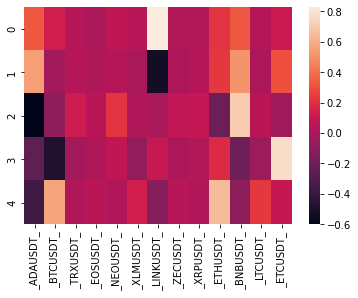

In [20]:
# plotting heatmap 
sns.heatmap(topPortfolios)

In [21]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #0 with the highest Sharpe. Return inf%, vol = 1816325.56%, Sharpe = 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.00
    Return           Vol         Sharpe
0      inf  1.816326e+04  1.797693e+308
1      inf  1.274237e+04  1.797693e+308
2      inf  4.746729e+04  1.797693e+308
3      inf  2.505920e+05  1.797693e+308
4      inf  1.937330e+04  1.797693e+308
5      inf  4.102663e+04  1.797693e+308
6      inf  1.241109e+05  1.797693e+308
7      inf  2.150029e+05  1.797693e+308
8      inf  1.056424e+05  1.797693e+308
9      inf  1.602870e+06  1.797693e+308
10     inf  5.371212e+04  1.797693e+308
11     inf  7.007864e+05  1.797693e+308
12     inf  3.649268e+04  1.797693e+308


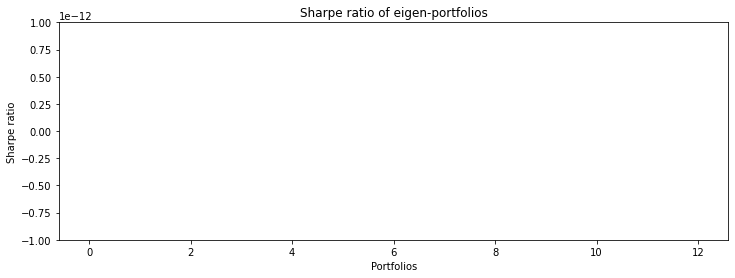

In [22]:
def optimizedPortfolio():
    #Initialize Arrays for saving values
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = ndata.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        pc_w = pcs[i] / sum(pcs[i])
        #print(pc_w,pc_w.squeeze() * 100)
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)
    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()
    
optimizedPortfolio()# results not upto mark 
#top portfolio has unrealstic Sharp ratio and returns 

In [ ]:
#ndata = (data_raw - data_raw.mean()) / data_raw.std()